# NLP Whitman and Blake

In [1]:

%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from gensim.models import doc2vec
from collections import namedtuple
nlp = spacy.load('en_core_web_sm')
import en_core_web_sm
import csv

C:\Users\mille\Conda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


For this challenge, you will need to choose a corpus of data from nltk or another source that includes categories you can predict and create an analysis pipeline that includes the following steps:

1. Data cleaning / processing / language parsing
2. Create features using two different NLP methods: For example, BoW vs tf-idf.
3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.
4. Assess your models using cross-validation and determine whether one model performed better.
5. Pick one of the models and try to increase accuracy by at least 5 percentage points.

In [20]:
import nltk
# Launch the installer to download "gutenberg" and "stop words" corpora.
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## 1. Data cleaning / processing / language parsing

In [21]:
# Import the data we just downloaded and installed.
from nltk.corpus import gutenberg, stopwords

# Grab and process the raw data.
print(gutenberg.fileids())


['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [22]:
whitman = gutenberg.raw('whitman-leaves.txt')
blake = gutenberg.raw('blake-poems.txt')

print('\nRaw:\n', whitman[0:100])
print('\nRaw:\n', blake[0:100])


Raw:
 [Leaves of Grass by Walt Whitman 1855]


Come, said my soul,
Such verses for my Body let us write, (

Raw:
 [Poems by William Blake 1789]

 
SONGS OF INNOCENCE AND OF EXPERIENCE
and THE BOOK of THEL


 SONGS 


In [23]:
# This pattern matches all text between square brackets.
pattern = "[\[].*?[\]]"
whitman = re.sub(pattern, "", whitman)
blake = re.sub(pattern, "", blake)

# Print the first 100 characters of Alice again.
print('Title removed:\n', whitman[0:100])
print('Title removed:\n', blake[0:100])

Title removed:
 


Come, said my soul,
Such verses for my Body let us write, (for we are one,)
That should I after r
Title removed:
 

 
SONGS OF INNOCENCE AND OF EXPERIENCE
and THE BOOK of THEL


 SONGS OF INNOCENCE
 
 
 INTRODUCTIO


In [24]:
# Now we'll match and remove chapter headings.
whitman = re.sub(r'Chapter \d+', '', whitman)
blake = re.sub(r'CHAPTER .*', '', blake)

# Ok, what's it look like now?
print('Chapter headings removed:\n', whitman[0:100])
print('Chapter headings removed:\n', blake[0:100])

Chapter headings removed:
 


Come, said my soul,
Such verses for my Body let us write, (for we are one,)
That should I after r
Chapter headings removed:
 

 
SONGS OF INNOCENCE AND OF EXPERIENCE
and THE BOOK of THEL


 SONGS OF INNOCENCE
 
 
 INTRODUCTIO


In [25]:
# Remove newlines and other extra whitespace by splitting and rejoining.
blake = ' '.join(blake.split())
whitman = ' '.join(whitman.split())

# All done with cleanup? Let's see how it looks.
print('Extra whitespace removed:\n', blake[0:100])
print('Extra whitespace removed:\n', whitman[0:100])

Extra whitespace removed:
 SONGS OF INNOCENCE AND OF EXPERIENCE and THE BOOK of THEL SONGS OF INNOCENCE INTRODUCTION Piping dow
Extra whitespace removed:
 Come, said my soul, Such verses for my Body let us write, (for we are one,) That should I after retu


In [26]:
# Here is a list of the stopwords identified by NLTK.
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [27]:
import en_core_web_sm
nlp = en_core_web_sm.load()

# All the processing work is done here, so it may take a while.
blake_doc = nlp(blake)
whitman_doc = nlp(whitman)

In [28]:
from collections import Counter

# Utility function to calculate how frequently words appear in the text.
def word_frequencies(text, include_stop=True):
    
    # Build a list of words.
    # Strip out punctuation and, optionally, stop words.
    words = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            words.append(token.text)
            
    # Build and return a Counter object containing word counts.
    return Counter(words)
    
# The most frequent words:
blake_freq = word_frequencies(blake_doc).most_common(10)
whitman_freq = word_frequencies(whitman_doc).most_common(10)
print('Blake:', blake_freq)
print('Whitman:', whitman_freq)

Blake: [('the', 351), ('And', 176), ('and', 169), ('of', 131), ('I', 130), ('in', 116), ('a', 108), ('to', 92), ('my', 72), ('The', 61)]
Whitman: [('the', 8809), ('and', 4794), ('of', 4123), ('I', 2924), ('to', 1930), ('in', 1713), ('you', 1345), ('The', 1294), ('with', 1111), ('a', 1092)]


In [29]:
# Use our optional keyword argument to remove stop words.
blake_freq = word_frequencies(blake_doc, include_stop=False).most_common(10)
whitman_freq = word_frequencies(whitman_doc, include_stop=False).most_common(10)
print('Blake:', blake_freq)
print('Whitman:', whitman_freq)

Blake: [('thee', 42), ('like', 29), ('thy', 28), ('thou', 28), ('little', 26), ('night', 25), ('away', 24), ('joy', 22), ('weep', 21), ('happy', 19)]
Whitman: [('O', 591), ('love', 259), ('day', 253), ('shall', 251), ('life', 247), ('soul', 239), ('old', 234), ('man', 230), ('earth', 226), ('long', 223)]


In [30]:
# Pull out just the text from our frequency lists.
blake_common = [pair[0] for pair in blake_freq]
whitman_common = [pair[0] for pair in whitman_freq]

# Use sets to find the unique values in each top ten.
print('Unique to Blake:', set(blake_common) - set(whitman_common))
print('Unique to Whitman:', set(whitman_common) - set(blake_common))

Unique to Blake: {'like', 'little', 'thee', 'joy', 'weep', 'night', 'happy', 'away', 'thou', 'thy'}
Unique to Whitman: {'man', 'life', 'love', 'day', 'earth', 'shall', 'old', 'soul', 'O', 'long'}


In [31]:
# Utility function to calculate how frequently lemas appear in the text.
def lemma_frequencies(text, include_stop=True):
    
    # Build a list of lemas.
    # Strip out punctuation and, optionally, stop words.
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_)
            
    # Build and return a Counter object containing word counts.
    return Counter(lemmas)

# Instantiate our list of most common lemmas.
blake_lemma_freq = lemma_frequencies(blake_doc, include_stop=False).most_common(10)
whitman_lemma_freq = lemma_frequencies(whitman_doc, include_stop=False).most_common(10)
print('\nBlake:', blake_lemma_freq)
print('Whitman:', whitman_lemma_freq)

# Again, identify the lemmas common to one text but not the other.
blake_lemma_common = [pair[0] for pair in blake_lemma_freq]
whitman_lemma_common = [pair[0] for pair in whitman_lemma_freq]
print('Unique to Blake:', set(blake_lemma_common) - set(whitman_lemma_common))
print('Unique to Whitman:', set(whitman_lemma_common) - set(blake_lemma_common))


Blake: [('thee', 42), ('little', 37), ('hear', 33), ('weep', 32), ('child', 30), ('thy', 29), ('like', 29), ('thou', 28), ('love', 27), ('night', 27)]
Whitman: [('o', 579), ('man', 430), ('love', 331), ('day', 323), ('come', 280), ('life', 273), ('soul', 263), ('shall', 251), ('know', 250), ('old', 249)]
Unique to Blake: {'like', 'little', 'thee', 'weep', 'night', 'hear', 'thou', 'thy', 'child'}
Unique to Whitman: {'man', 'life', 'o', 'day', 'know', 'shall', 'old', 'come', 'soul'}


In [32]:
# Initial exploration of sentences.
sentences = list(blake_doc.sents)
print("Blake has {} sentences.".format(len(sentences)))

example_sentence = sentences[2]
print("Here is an example: \n{}\n".format(example_sentence))

Blake has 584 sentences.
Here is an example: 
wild



In [33]:
# Initial exploration of sentences.
sentences = list(whitman_doc.sents)
print("Whitman has {} sentences.".format(len(sentences)))

example_sentence = sentences[2]
print("Here is an example: \n{}\n".format(example_sentence))

Whitman has 6151 sentences.
Here is an example: 
I Sing One's-self



In [34]:
# Look at some metrics around this sentence.
example_words = [token for token in example_sentence if not token.is_punct]
unique_words = set([token.text for token in example_words])

print(("There are {} words in this sentence, and {} of them are"
       " unique.").format(len(example_words), len(unique_words)))

There are 4 words in this sentence, and 4 of them are unique.


# Standard text cleaning 

In [35]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
whitman = gutenberg.raw('whitman-leaves.txt')
blake = gutenberg.raw('blake-poems.txt')

# The Chapter indicator is idiosyncratic
whitman = re.sub(r'Chapter \d+', '', whitman)
blake = re.sub(r'CHAPTER .*', '', blake)
    
blake = text_cleaner(blake[:int(len(blake)/10)])
whitman = text_cleaner(whitman[:int(len(whitman)/10)])

In [36]:
# Group into sentences.
blake_sents = [[sent, "Blake"] for sent in blake_doc.sents]
whitman_sents = [[sent, "Whitman"] for sent in whitman_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(blake_sents + whitman_sents)
sentences.head()

,0,1
0,"(SONGS, OF, INNOCENCE, AND, OF, EXPERIENCE, an...",Blake
1,"(INNOCENCE, INTRODUCTION, Piping, down, the, v...",Blake
2,(wild),Blake
3,"(,, Piping, songs, of, pleasant, glee, ,, On, ...",Blake
4,"("", Pipe, a, song, about, a, Lamb, !, "")",Blake


## Bag of Words 

In [37]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 700 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
blakewords = bag_of_words(blake_doc)
whitmanwords = bag_of_words(whitman_doc)

# Combine bags to create a set of unique words.
common_words = set(blakewords + whitmanwords)

In [38]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 700
Processing row 1400
Processing row 2100
Processing row 2800
Processing row 3500
Processing row 4200
Processing row 4900
Processing row 5600
Processing row 6300


,beetle,scorn,aged,lightning,Jack,divine,brown,measur'd,breathe,lustrous,...,make,continue,seest,flight,inhaling,inure,real,region,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(SONGS, OF, INNOCENCE, AND, OF, EXPERIENCE, an...",Blake
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(INNOCENCE, INTRODUCTION, Piping, down, the, v...",Blake
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,(wild),Blake
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(,, Piping, songs, of, pleasant, glee, ,, On, ...",Blake
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"("", Pipe, a, song, about, a, Lamb, !, "")",Blake


In [39]:
print(len(common_words))

2699


# Models

1. Logistic regression 
2. Naive Bayes
3. Gradient Boosting
4. Random Forest 
5. Linear SVM
6. Stocastich Gradient Descent 

### Model imports sklearn

In [102]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn import metrics


# Logistic Regression 

In [103]:
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

In [104]:
# Apply to testing data
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

train = lr.fit(X_train, y_train)

lr = LogisticRegression()
train = lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)

C:\Users\mille\Conda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mille\Conda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Bag of Words Logistic Regression

In [105]:

#fit lr

lr.fit(X_train, y_train)

# Apply to testing data
y_hat = lr.predict(X_test)

cross = pd.crosstab(y_hat, y_test)

print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))
print(classification_report(y_test, y_hat))
print(cross)

C:\Users\mille\Conda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set score: 0.9626330116307844

Test set score: 0.9302152932442465
              precision    recall  f1-score   support

       Blake       0.88      0.25      0.39       240
     Whitman       0.93      1.00      0.96      2454

   micro avg       0.93      0.93      0.93      2694
   macro avg       0.91      0.62      0.68      2694
weighted avg       0.93      0.93      0.91      2694

text_source  Blake  Whitman
row_0                      
Blake           60        8
Whitman        180     2446


## Bag of words Naive Bayes

In [106]:
from sklearn.naive_bayes import GaussianNB


#Initialize and fit
nb = GaussianNB()
nb.fit(X_train, y_train)

# Apply to testing data
y_hat = nb.predict(X_test)

# Showing model performance
cross = pd.crosstab(y_hat, y_test)
print('Training set score:', nb.score(X_train, y_train))
print('\nTest set score:', nb.score(X_test, y_test))
print("Accuracy is: %0.3f" % nb.score(X_test, y_test))
print(classification_report(y_test, y_hat))
print(cross)

Training set score: 0.8272704776045533

Test set score: 0.7847067557535263
Accuracy is: 0.785
              precision    recall  f1-score   support

       Blake       0.24      0.65      0.35       240
     Whitman       0.96      0.80      0.87      2454

   micro avg       0.78      0.78      0.78      2694
   macro avg       0.60      0.72      0.61      2694
weighted avg       0.89      0.78      0.82      2694

text_source  Blake  Whitman
row_0                      
Blake          156      496
Whitman         84     1958


## Bag of words Gradient Boosting 

In [47]:
clf = ensemble.GradientBoostingClassifier()



clf.fit(X_train, y_train)

# Apply to testing data
y_hat = clf.predict(X_test)

train = clf.fit(X_train, y_train)
print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))
print(classification_report(y_test, y_hat))
print(cross)

Training set score: 0.9334323187329869

Test set score: 0.9213066072754269
              precision    recall  f1-score   support

       Blake       0.89      0.14      0.24       240
     Whitman       0.92      1.00      0.96      2454

   micro avg       0.92      0.92      0.92      2694
   macro avg       0.91      0.57      0.60      2694
weighted avg       0.92      0.92      0.90      2694

text_source  Blake  Whitman
row_0                      
Blake          156      496
Whitman         84     1958


## Bag of words Random Forest

In [48]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))


rfc.fit(X_train, y_train)

# Apply to testing data
y_hat = rfc.predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))
print(classification_report(y_test, y_hat))
print(cross)

C:\Users\mille\Conda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9888641425389755

Test set score: 0.9227913882702301
              precision    recall  f1-score   support

       Blake       0.59      0.35      0.44       240
     Whitman       0.94      0.98      0.96      2454

   micro avg       0.92      0.92      0.92      2694
   macro avg       0.76      0.66      0.70      2694
weighted avg       0.91      0.92      0.91      2694

text_source  Blake  Whitman
row_0                      
Blake          156      496
Whitman         84     1958


## Bag of words Linear SVM 

In [107]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix


# Create instance and fit
sv = SVC(kernel='linear')
sv.fit(X_train, y_train)

# Apply to testing data
y_hat = sv.predict(X_test)

# Showing model performance
cross = pd.crosstab(y_hat, y_test)
print('Training set score:', sv.score(X_train, y_train))
print('\nTest set score:', sv.score(X_test, y_test))
print("Accuracy is: %0.3f" % sv.score(X_test, y_test))
print(classification_report(y_test, y_hat))
print(cross)

Training set score: 0.9829250185597624

Test set score: 0.9357832219747587
Accuracy is: 0.936
              precision    recall  f1-score   support

       Blake       0.74      0.42      0.54       240
     Whitman       0.95      0.99      0.97      2454

   micro avg       0.94      0.94      0.94      2694
   macro avg       0.85      0.71      0.75      2694
weighted avg       0.93      0.94      0.93      2694

text_source  Blake  Whitman
row_0                      
Blake          102       35
Whitman        138     2419


## Bag of words Stocastic Gradient Descent

In [108]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics


# Create instance and fit
sgdc = SGDClassifier(loss = 'hinge')
sgdc.fit(X_train, y_train)

# Apply to testing data
y_hat = sgdc.predict(X_test)


# Showing model performance
cross = pd.crosstab(y_hat, y_test)
print('Training set score:', sgdc.score(X_train, y_train))
print('\nTest set score:', sgdc.score(X_test, y_test))
print("Accuracy is: %0.3f" % sgdc.score(X_test, y_test))
print(classification_report(y_test, y_hat))
print(cross)

C:\Users\mille\Conda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Training set score: 0.9772333580796833

Test set score: 0.9261321455085375
Accuracy is: 0.926
              precision    recall  f1-score   support

       Blake       0.58      0.62      0.60       240
     Whitman       0.96      0.96      0.96      2454

   micro avg       0.93      0.93      0.93      2694
   macro avg       0.77      0.79      0.78      2694
weighted avg       0.93      0.93      0.93      2694

text_source  Blake  Whitman
row_0                      
Blake          149      108
Whitman         91     2346


# Summary of Bag of Words supervised results
<img src="https://raw.githubusercontent.com/DMiller78/NLP/master/Screenshot%20(39).png">

The best overall model for the Bag of Words in a supervised model is Stocastic Gradient Descent. Has a high training and test set score accuracy. With a f1-score of 0.96 for Whitman and 0.60 for Blake, and containing a f1 0.93 weighted average. 

The Linear SVM very similar to Stocastic Gradient Descent model only difference is 0.06 f1-score for Blake. 

Take aways: 

All the models except for Naive Bayes (0.87) have f1-scores of 0.96 or higher. However, the f1-scores were much lower in the Blake text analysis. With Gradient Boosting the lowest score at 0.24 and Stocastic Gradient Descent at the highest at 0.60. 



# Unsupervised NLP

In [80]:
#reading in the data, this time in the form of paragraphs
whitman = gutenberg.paras('whitman-leaves.txt')
blake = gutenberg.paras('blake-poems.txt')


#processingwnload()

whitman_paras = []
blake_paras=[]


## Walt Whitman

### Increased percentage points: Pick one of the models and try to increase accuracy by at least 5 percentage points.

Initial run the Whitman text captured variance = 29% 

Adjusting model - second attempt 
changed: svd= TruncatedSVD from 130 to 250 
captured variance = 35% 



In [109]:

for paragraph in whitman:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    whitman_paras.append(' '.join(para))

print(whitman_paras[0:4])

['[ Leaves of Grass by Walt Whitman 1855 ]', "Come , said my soul , Such verses for my Body let us write , ( for we are one ,) That should I after return , Or , long , long hence , in other spheres , There to some group of mates the chants resuming , ( Tallying Earth ' s soil , trees , winds , tumultuous waves ,) Ever with pleas ' d smile I may keep on , Ever and ever yet the verses owning  as , first , I here and now Signing for Soul and Body , set to them my name ,", 'Walt Whitman', '[ BOOK I . INSCRIPTIONS ]']


In [110]:

from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(whitman_paras, test_size=0.40, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [111]:
#Applying the vectorizer
whitman_paras_tfidf=vectorizer.fit_transform(whitman_paras)
print("Number of features: %d" % whitman_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(whitman_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[3])
print('Tf_idf vector:', tfidf_bypara[3])

Number of features: 10346
Original sentence: } As I Ponder ' d in Silence
Tf_idf vector: {'silence': 0.6441482774256716, 'ponder': 0.7649006449791632}


In [112]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(250)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 35.22813400115369
Component 0:
Spontaneous me , Nature , The loving day , the mounting sun , the friend I am happy with , The arm of my friend hanging idly over my shoulder , The hillside whiten ' d with blossoms of the mountain ash , The same late in autumn , the hues of red , yellow , drab , purple , and light and dark green , The rich coverlet of the grass , animals and birds , the private untrimm ' d bank , the primitive apples , the pebble - stones , Beautiful dripping fragments , the negligent list of one after another as I happen to call them to me or think of them , The real poems , ( what we call poems being merely pictures ,) The poems of the privacy of the night , and of men like me , This poem drooping shy and unseen that I always carry , and that all men carry , ( Know once for all , avow ' d on purpose , wherever are men like me , are our lusty lurking masculine poems ,) Love - thoughts , love - juice , love - odor , love - yie

Name: 0, dtype: float64
Component 1:
[ BOOK X ]                   0.997126
[ BOOK X ]                   0.997126
[ BOOK X ]                   0.997126
[ BOOK XXXIII .              0.996771
[ BOOK XXVIII ]              0.996771
[ BOOK I . INSCRIPTIONS ]    0.996771
[ BOOK XV ]                  0.996239
[ BOOK XV ]                  0.996239
[ BOOK XXV ]                 0.996237
[ BOOK XXV ]                 0.996237
Name: 1, dtype: float64
Component 2:
6 What will be will be well , for what is is well , To take interest is well , and not to take interest shall be well .                                                                                                                                                                                                                                                                                                                                                                                                                                           

Name: 2, dtype: float64
Component 3:
} Thought                                  0.934488
} Thought                                  0.934488
} Thought                                  0.934488
} Thought                                  0.934488
} Thought                                  0.934488
} Thought                                  0.934488
} Thought                                  0.934488
} Thought                                  0.934488
} Thought                                  0.934488
Why what have you thought of yourself ?    0.934488
Name: 3, dtype: float64
Component 4:
6 What will be will be well , for what is is well , To take interest is well , and not to take interest shall be well .                                                                                                                                                                                                                                                                                               

Name: 4, dtype: float64


## Percent of variance captured: 35.6% 

Component 0: Very large portions of text, roughly 30 lines (sentences). Poorly captured

Component 1: Contains the chapter headings. This is captured very well with 99% accuracy. 

Component 2: Again very high capturing of the variance at 97.7%

Component 3: Shorter sentences (2) 

Component 4: Life/Death again has an accuracy at 64%. 

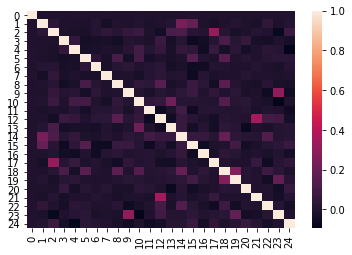

Key:
0 [ BOOK XXXI ]
1 O to make the most jubilant song !
2 I seize the descending man and raise him with resistless will , O despairer , here is my neck , By God , you shall not go down !
3 } As I Ponder ' d in Silence
4 } Vocalism
5 The wife , and she is not one jot less than the husband , The daughter , and she is just as good as the son , The mother , and she is every bit as much as the father .
6 } Laws for Creations
7 How curious !
8 In one , the sacred parturition scene , A happy painless mother birth ' d a perfect child .
9 Life ' s involv ' d and varied pageants , All the forms and shows , all the workmen at their work , All the seamen and the landsmen , all the masters with their slaves , Pioneers !
10 I saw the marriage of the trapper in the open air in the far west , the bride was a red girl , Her father and his friends sat near cross - legged and dumbly smoking , they had moccasins to their feet and large thick blankets hanging from their shoulders , On a bank lounged the 

In [114]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:25,0:25]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(25))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(25):
    print(i,sim_matrix.index[i])

### Correlation heatmap

Very low correlations between the first 25 sentences. The correlation values are 0.40 (highest) or lower.

# Blake

## Blake tfid vectorizer

In [115]:
for paragraph in blake:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    blake_paras.append(' '.join(para))

print(blake_paras[0:4])

['[ Poems by William Blake 1789 ]', 'SONGS OF INNOCENCE AND OF EXPERIENCE and THE BOOK of THEL', 'SONGS OF INNOCENCE', 'INTRODUCTION']


In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(blake_paras, test_size=0.40, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [117]:
#Applying the vectorizer
blake_paras_tfidf=vectorizer.fit_transform(blake_paras)
print("Number of features: %d" % blake_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(blake_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[3])
print('Tf_idf vector:', tfidf_bypara[3])

Number of features: 404
Original sentence: Farewell , green fields and happy grove , Where flocks have ta ' en delight .
Tf_idf vector: {'flocks': 0.46672519749728086, 'fields': 0.46672519749728086, 'grove': 0.4425495676260918, 'delight': 0.35022666465050994, 'green': 0.3575387464453752, 'happy': 0.34350020144718485}


In [118]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 97.27473447165617
Component 0:
A LITTLE BOY LOST                                                                                                                                         0.829379
THE LITTLE BOY LOST                                                                                                                                       0.829379
THE LITTLE BOY FOUND                                                                                                                                      0.738615
A LITTLE GIRL LOST                                                                                                                                        0.702563
THE LITTLE GIRL LOST                                                                                                                                      0.702563
THE LITTLE BLACK BOY                                                                                         

Name: 4, dtype: float64


## **Percent of variance captured: 97%**

Component 0: Variations of the words "A little boy lost" at 82.9% the least accurate was "He kissed the child , and by the hand led , And to his mother brought , Who in sorrow pale , through the lonely dale , The little boy weeping sought" at 36.6% 
Overall component values ranged from 82.9% to 36.6% with an average = 64.1% 

Component 1: The accuracy values are much lower in component 1. Range from 43.7% to 32.5% 
average = 38.% 

Component 2: The accuracy value are consistent for 4 of the trials. Range from 77.8% to 13.9%
average = 49.2% 

Component 3:  The accuracy values are low similar to component 1. 
average = 37.4%

Component 4: Contains the lowest accuracy ranging from 51% to 26% with an average of 35.2% 


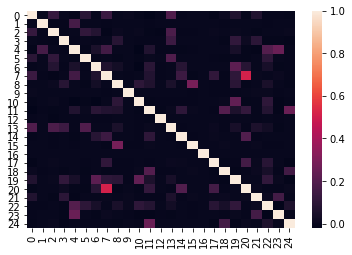

Key:
0 Then come home , my children , the sun is gone down , And the dews of night arise ; Your spring and your day are wasted in play , And your winter and night in disguise .
1 HOLY THURSDAY
2 " Does spring hide its joy , When buds and blossoms grow ?
3 Farewell , green fields and happy grove , Where flocks have ta ' en delight .
4 Sweet babe , in thy face Holy image I can trace ; Sweet babe , once like thee Thy Maker lay , and wept for me :
5 The sun descending in the west , The evening star does shine ; The birds are silent in their nest , And I must seek for mine .
6 I ' ll shade him from the heat till he can bear To lean in joy upon our Father ' s knee ; And then I ' ll stand and stroke his silver hair , And be like him , and he will then love me .
7 " Sweet sleep , come to me Underneath this tree ; Do father , mother , weep ?
8 The modest Rose puts forth a thorn , The humble sheep a threat ' ning horn : While the Lily white shall in love delight , Nor a thorn nor a threat stain 

In [119]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:25,0:25]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(25))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(25):
    print(i,sim_matrix.index[i])

### Correlation heatmap 

There is a slight correlation between sentence 7 and 20 near a 0.60. Overall the correlations are less then that obeserved in Whitman text. 

# Discussion

The unsupervised TfidfVectorizer out performed the supervised models only with the text analysis of Blake. The TfidfVectorizer model caputed 97% of the variance in the model. Whereas the Whitman text only captured 29% on the first pass and 35% when change the number of features. 

